# Figure 2: Hypothesis-driven and discovery-driven analysis with CEBRA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


In [2]:
data = pd.read_hdf("../data/Figure2.h5", key="data")

## Figure 2b

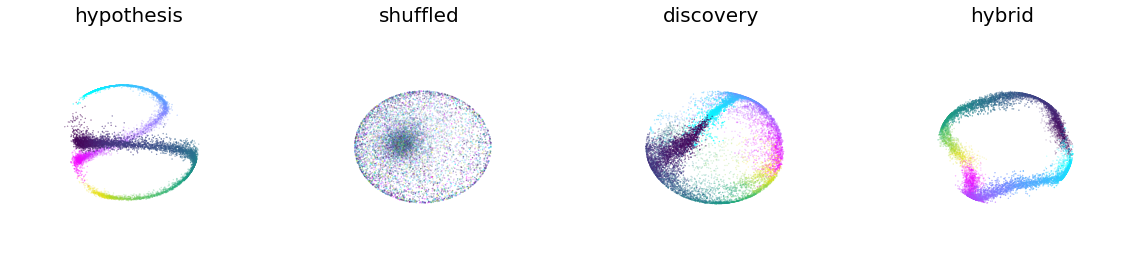

In [3]:
method_viz = data["visualization"]

fig = plt.figure(figsize=(20, 5))
for i, model in enumerate(["hypothesis", "shuffled", "discovery", "hybrid"]):
    ax = fig.add_subplot(1, 4, i + 1, projection="3d")
    emb = method_viz[model]["embedding"]
    label = method_viz[model]["label"]
    r = label[:, 1] == 1
    l = label[:, 2] == 1
    idx1, idx2, idx3 = (0, 1, 2)
    if i == 3:
        idx1, idx2, idx3 = (1, 2, 0)
    ax.scatter(
        emb[l, idx1], emb[l, idx2], emb[l, idx3], c=label[l, 0], cmap="cool", s=0.1
    )
    ax.scatter(emb[r, idx1], emb[r, idx2], emb[r, idx3], c=label[r, 0], s=0.1)
    ax.axis("off")
    ax.set_title(f"{model}", fontsize=20)

## Figure 2c

In [4]:
# TODO hypothesis testing plot

## Figure 2d

In [5]:
# TODO decoding visualization

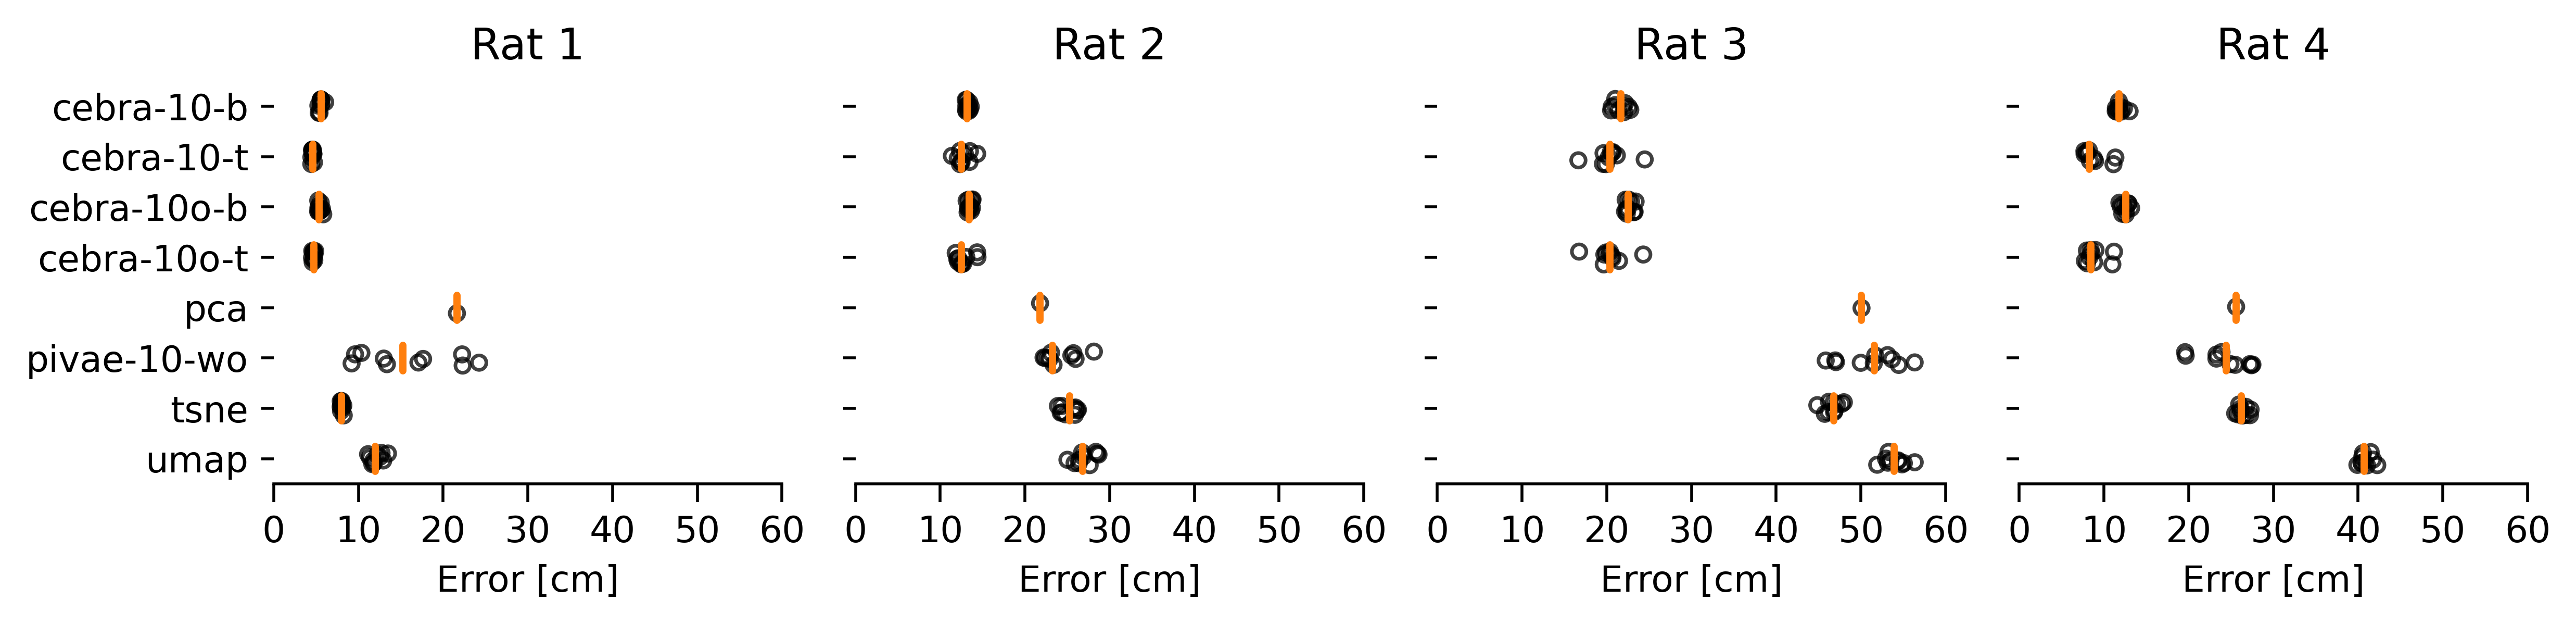

In [6]:
"""Decoding plot (Figure 2 and supplementary figure)"""

import pandas as pd
import numpy as np
import pathlib

ROOT = pathlib.Path("../data")


def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element


def load_results(result_name):
    """Load a result file.

    The first line in the result files specify the index columns,
    the following lines are a CSV formatted file containing the
    numerical results.
    """
    results = {}
    for result_csv in (ROOT / result_name).glob("*.csv"):
        with open(result_csv) as fh:
            index_names = fh.readline().strip().split(",")
            df = pd.read_csv(fh).set_index(index_names)
            df = df.applymap(recover_python_datatypes)
            results[result_csv.stem] = df
    return results


results = load_results(result_name="results_v4")
len(results)

from matplotlib.markers import MarkerStyle
import warnings
import typing
import seaborn as sns
import matplotlib.pyplot as plt


def show_boxplot(df, metric, ax, labels=None, color="C1"):

    sns.set_style("white")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        sns.boxplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            order=labels,  # unique(labels.values()),
            # hue = "rat",
            width=0.5,
            color="k",
            linewidth=2,
            flierprops=dict(alpha=0.5, markersize=0, marker=".", linewidth=0),
            medianprops=dict(
                c=color, markersize=0, marker=".", linewidth=2, solid_capstyle="round"
            ),
            whiskerprops=dict(solid_capstyle="butt", linewidth=0),
            # capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
            showbox=False,
            showcaps=False,
            # shownotches = True
            ax=ax,
        )
        marker_style = MarkerStyle("o", "none")

        sns.stripplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            size=4,
            color="black",
            order=labels,
            marker=marker_style,
            linewidth=1,
            ax=ax,
            alpha=0.75,
            jitter=0.15,
            zorder=-1,
        )
        # sns.despine(left = True, ax = ax)
        # ax.get_legend().remove()
        ax.set_ylabel("")
        sns.despine(left=True, bottom=False, ax=ax)
        # ax.tick_params(axis = 'x', length = 2, colors = "black")
        ax.tick_params(
            axis="x", which="both", bottom=True, top=False, length=5, labelbottom=True
        )
        return ax


def _add_value(df, **kwargs):
    for key, value in kwargs.items():
        df[key] = value
    return df


def join(results):
    return pd.concat([_add_value(df, method=key) for key, df in results.items()])


metadata = [
    (
        "test_position_error",
        "Decoding (positional error)",
        100,
        "Error [cm]",
        [0, 10, 20, 30, 40, 50, 60],
    ),
]


def plot_decoding_overview(results_best):

    results_ = join(results_best)
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), dpi=500, sharey=True, sharex=True)

    # label_order = tuple(results_best.keys())

    def _agg(v):
        return sum(v) / len(v)

    for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):
        table = (
            results_.reset_index(drop=True)
            .pivot_table(
                metric,
                index=["animal", "repeat"],
                columns=["method"],
                aggfunc=list,  # lambda v : list(itertools.chain.from_iterable(v) if isinstance(v, list) else list(v))
            )
            .applymap(
                lambda v: list(
                    itertools.chain.from_iterable(v)
                    if isinstance(v[0], typing.Iterable)
                    else v
                )
            )
            .groupby("animal", level=0)
            .agg(lambda v: np.stack(v).mean(0))
        )

        for animal in table.index:
            df = table.loc[animal].reset_index()
            df.columns = "method", "metric"
            df = df.explode("metric")
            df["metric"] *= scale

            label_order = sorted(tuple(df.method.unique()))

            show_boxplot(
                df=df,
                metric="metric",
                ax=axes[animal],
                color="C2" if ("svm" in metric) else "C1",
            )
            ax = axes[animal]
            ax.set_xlabel(xlabel)
            ax.set_xticks(xlim)
            ax.spines["bottom"].set_bounds(min(xlim), max(xlim))

            # axes[0, metric_id].set_title(metric_name, fontsize = 10)
            # axes[animal, 0].set_ylabel(f"Rat {animal+1}")

            # ax.set_yticklabels([
            #  "CEBRA-Behavior",
            #  "pi-VAE, MCMC",
            #  "CEBRA-Time",
            #  "pi-VAE, kNN",
            #  "t-SNE",
            #  "UMAP",
            #  "PCA"
            # ])
            ax.set_ylabel("")
            ax.set_title(f"Rat {animal+1}")

    plt.tight_layout()


plot_decoding_overview(results)

## Figure 2f

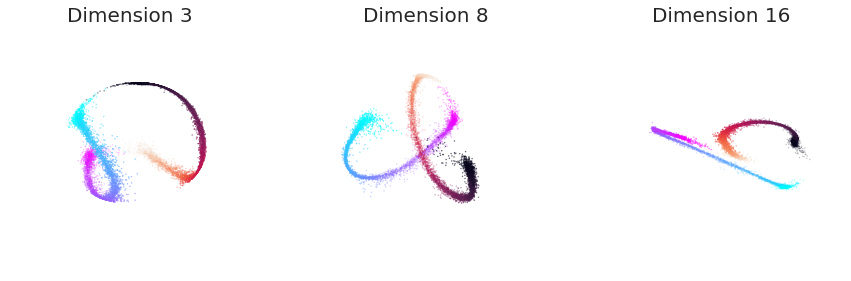

In [7]:
topology_viz = data["topology"]["viz"]

fig = plt.figure(figsize=(15, 5))
for i, dim in enumerate([3, 8, 16]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    emb = topology_viz[dim]
    label = topology_viz["label"]
    r = label[:, 1] == 1
    l = label[:, 2] == 1
    idx1, idx2, idx3 = (0, 1, 2)
    if i == 1:
        idx1, idx2, idx3 = (5, 6, 7)
    ax.scatter(
        emb[l, idx1], emb[l, idx2], emb[l, idx3], c=label[l, 0], cmap="cool", s=0.1
    )
    ax.scatter(emb[r, idx1], emb[r, idx2], emb[r, idx3], c=label[r, 0], s=0.1)
    ax.axis("off")
    ax.set_title(f"Dimension {dim}", fontsize=20)

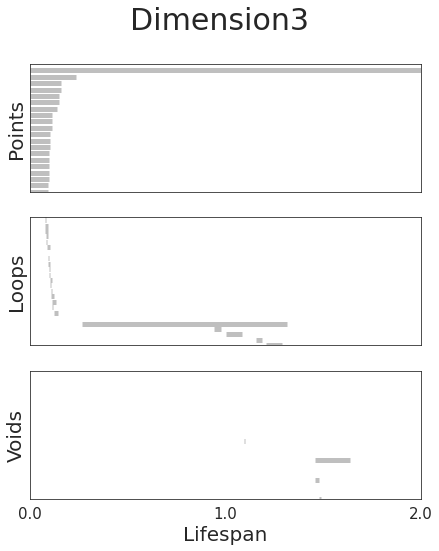

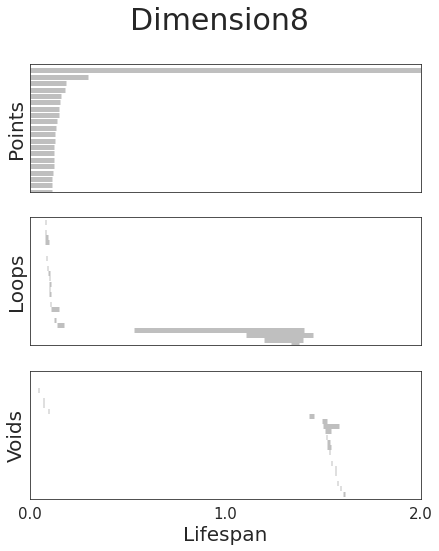

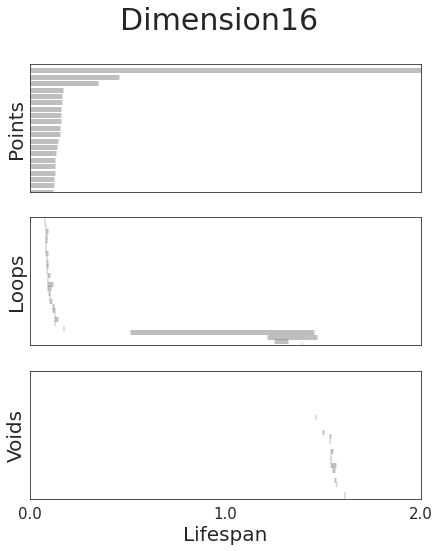

In [8]:
dims = [3, 8, 16]
cocycle = ["Points", "Loops", "Voids"]
colors = ["b", "orange", "green"]
for d in range(3):
    topology_result = data["topology"]["behavior_topology"][dims[d]][
        "dgms"
    ]  # analysis_offsets[d]['dgms']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 8))
    fig.suptitle(f"Dimension{dims[d]}", fontsize=30)
    axs[0].set_xlim(0, 2)

    for k in range(3):
        bars = topology_result[k]
        bars[bars == np.inf] = 10
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 1 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np.linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)